In [10]:
import scipy.stats
import numpy as np
import os, sys,  json, math
import matplotlib
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import time
import six
import sys
import os
import json, math

import seaborn as sns
plt.style.use(['classic', 'seaborn-deep', 'seaborn-dark'])
sns.set(style='whitegrid')

In [15]:
def accuracy(truth, output_sum):
    pred_truth = np.array(truth) == np.argmax(np.array(output_sum), axis=1)
    if len(pred_truth) == 0:
        return 0    
    return sum(pred_truth) / len(pred_truth)

def baselin_acc(eval_data):
    truth  = eval_data['pred_truth']
    output_sum      = eval_data['argmax_sum']
    adv_output_sums = eval_data['adv_argmax_sum']
    
    return  accuracy(truth, output_sum)

def all_y(eval_data, x, curve_y):
    for t in x:
        # The min is in case of multiple restarts
        y = [min(l) > t for l in eval_data['adversarial_norm']]
        curve_y.append(sum(y) / len(y))
    
    return curve_y
#     curves_y.append(curve_y)

### Attack Norm Bound L Comparison

In [167]:
L_list = [0.1, 0.3, 0.5, 1.0]
PATH_list = ['eval_json/L_{}/eval_data.json'.format(L) for L in L_list]

eval_json_list = []
for PATH in PATH_list:
    with open(PATH) as f:
        eval_json_list.append(json.loads(f.read()))

In [401]:
with open('eval_json/baseline/eval_data.json') as f:
    baseline_eval_data = json.loads(f.read())
    

In [402]:
x = [x for x in range(1, 32)]

y_list = []

# Baseline y
baseline_y = [0]
baseline_y[0] = baselin_acc(baseline_eval_data)
baseline_y = all_y(baseline_eval_data, x, baseline_y)
y_list.append(baseline_y)

for eval_data in eval_json_list:
    curve_y = [0]
    curve_y[0] = baselin_acc(eval_data)
    curve_y = all_y(eval_data, x, curve_y)
    y_list.append(curve_y)
    


x = [0] + x  # for the baseline


<Figure size 432x288 with 0 Axes>

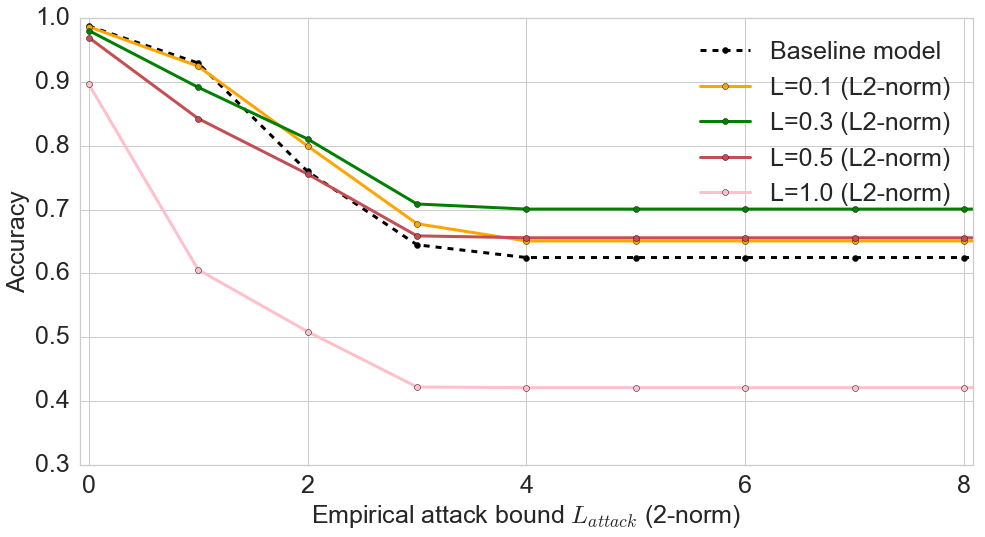

In [172]:
color_list = ['black', "orange", "green", "r", "pink"]
linestyle_list = ['--', '-', '-', '-' , '-']
fontsize = 25

plt.clf()
fig, (ax) = plt.subplots(1, 1, figsize=(16, 8))
x_range=(0, 8.0)
x_offset = max(x_range)*0.01
plt.xlim((x_range[0]-x_offset, x_range[1]+x_offset))
plt.ylim(0.3, 1.0)
artists = []

curves_labels = []


for i, y in enumerate(y_list):
    if i == 0:
        label = "Baseline model"
    else:
        L = L_list[i-1]
        label = "L={} (L2-norm)".format(L)
    curves_labels.append(label)
    art, = plt.plot(
        x, y,
        color=color_list[i],
        linestyle=linestyle_list[i],
        linewidth=3,
        label=label,
        marker='o'
    )
    artists.append([None, None, art])
    ax.set(xlabel=r'Empirical attack bound $L_{attack}$ (2-norm)', ylabel=r'Accuracy')

    l = plt.legend(
        handles=[x[2] for x in artists],
        loc=1,
        fontsize=fontsize)
    l.set_zorder(20)  # put the legend on top
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontsize(fontsize)
        
    ax.xaxis.label.set_fontsize(fontsize)
    ax.yaxis.label.set_fontsize(fontsize)

plt.savefig('attack_size_L')
plt.show()


## Robust Precision


In [423]:

def robust_accuracy_survival_ps(curves_x, pred_truth, robustness):
    true_and_robust_n = sum(pred_truth)
    d      = sorted(zip(robustness, pred_truth))
    tot    = len(d)
    robust = tot
    robust_acc_survival_p = []
    for x in curves_x:
        obs_index = tot - robust
        while obs_index < tot and d[obs_index][0] < x:
            if d[obs_index][1]:
                true_and_robust_n -= 1
            robust -= 1
            obs_index += 1
        robust_acc_survival_p.append(true_and_robust_n / tot)

    return robust_acc_survival_p



x_range=(0, 1, 0.1)
x = np.arange(x_range[0], x_range[1]+x_range[2], x_range[2]).tolist()
curves_y = []

eval_tmp = eval_json_list[0]
for eval_data in eval_json_list:
    truth = eval_data['pred_truth']
    output_sum = eval_data['argmax_sum']
    pred_truth = np.array(truth) == np.argmax(np.array(output_sum), axis=1)
    robustness = eval_data['robustness_from_argmax']
    ps = robust_accuracy_survival_ps(x, pred_truth, robustness)
    curves_y.append(ps)



<Figure size 432x288 with 0 Axes>

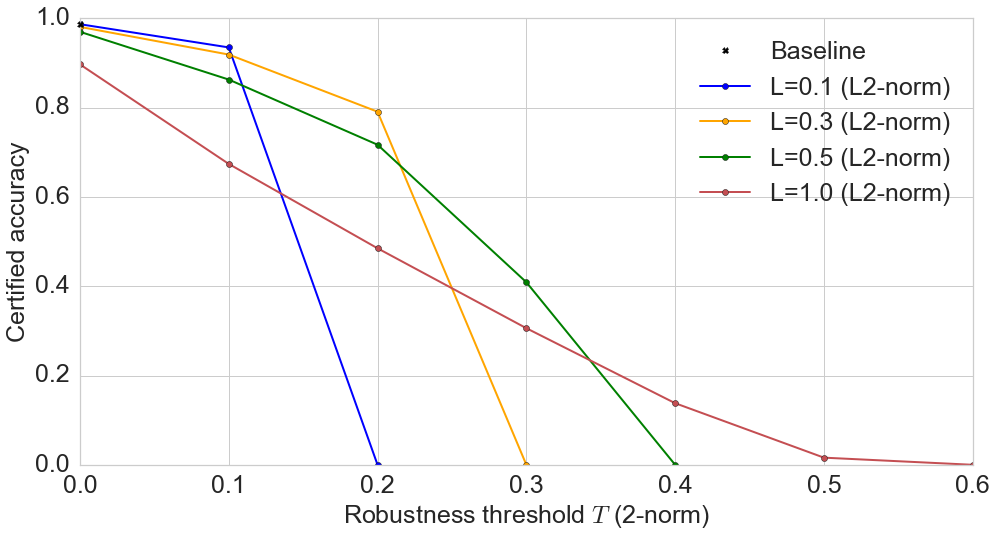

In [429]:
color_list = ['blue', "orange", "green", "r", "pink"]
linestyle_list = ['--', '-', '-', '-' , '-']

plt.clf()
fig, (ax) = plt.subplots(1, 1, figsize=(16, 8))
# x_offset = max(x_range)*0.01
# # plt.xlim((x_range[0]-x_offset, x_range[1]+x_offset))
# # plt.ylim((-0.02, 1.0))
# # plt.xlim((0.0, 0.8))
# # plt.ylim((3.3, 4.4))


artists = []

curves_labels = []
for i, y in enumerate(curves_y):
    label = "L={} (L2-norm)".format(L_list[i])
    
    curves_labels.append(label)
    j = len(x) - 1
    while y[j-1] == 0:
        j -= 1
    art, = plt.plot(
            x[:j+1], y[:j+1],
        color=color_list[i],
        linewidth=2,
        label=label,
        marker='o',
#         markersize=plots.utils.markersize
    )
    artists.append([None, None, art])

art, = plt.plot(
    [0.0],
    baseline_y[0],
    label="Baseline",
    linestyle="none",
    color="0.0",
    clip_on=False,
    zorder=11,
    marker="X",
#     markersize=plots.utils.markersize
)
artists = [[None, None, art]] + artists
ax.set(xlabel=r'Robustness threshold $T$ (2-norm)', ylabel=r'Certified accuracy')
l = plt.legend(
    handles=[x[2] for x in artists],
    loc=1,
    fontsize=fontsize
)

l.set_zorder(20)  # put the legend on top
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fontsize)
ax.xaxis.label.set_fontsize(fontsize)
ax.yaxis.label.set_fontsize(fontsize)

plt.savefig('certified_acc')
plt.show()

### Noise Layer Position Comparison

In [141]:
layer_list = [0, 1, 2]
PATH_list = ['eval_json/layer_{}/eval_data.json'.format(layer) for layer in layer_list]

eval_json_list = []
for PATH in PATH_list:
    with open(PATH) as f:
        eval_json_list.append(json.loads(f.read()))

In [142]:
x = [x for x in range(1, 32)]

y_list = []

# Baseline y
baseline_y = [0]
baseline_y[0] = baselin_acc(baseline_eval_data)
baseline_y = all_y(baseline_eval_data, x, baseline_y)
y_list.append(baseline_y)

for eval_data in eval_json_list:
    curve_y = [0]
    curve_y[0] = baselin_acc(eval_data)
    curve_y = all_y(eval_data, x, curve_y)
    y_list.append(curve_y)
    


x = [0] + x  # for the baseline

<Figure size 432x288 with 0 Axes>

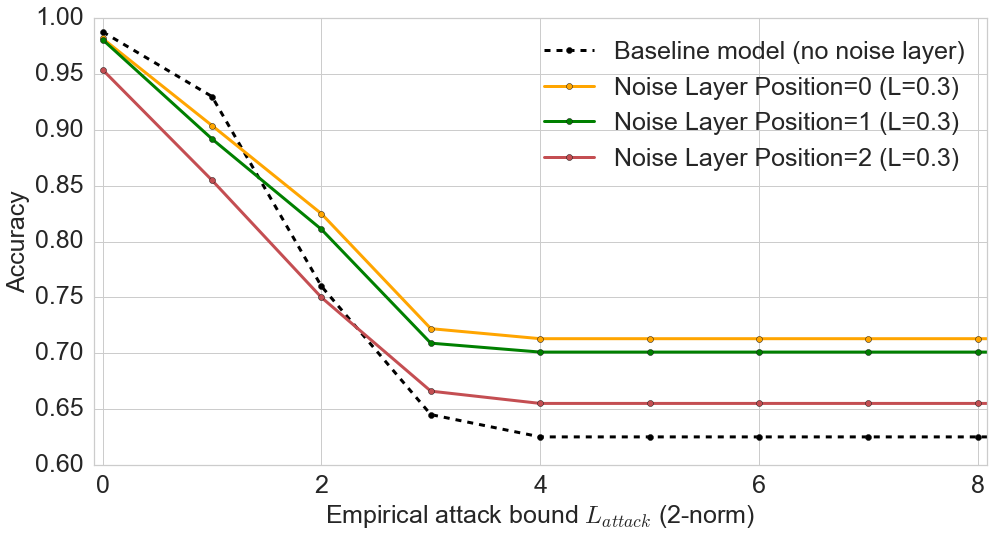

In [143]:
color_list = ['black', "orange", "green", "r", "darkred"]
linestyle_list = ['--', '-', '-', '-' , '-']

plt.clf()
fig, (ax) = plt.subplots(1, 1, figsize=(16, 8))
x_range=(0, 8.0)
x_offset = max(x_range)*0.01
plt.xlim((x_range[0]-x_offset, x_range[1]+x_offset))
plt.ylim(0.6, 1.0)
artists = []

curves_labels = []


for i, y in enumerate(y_list):
    if i == 0:
        label = "Baseline model (no noise layer)"
    else:
        layer = layer_list[i-1]
        label = "Noise Layer Position={} (L=0.3)".format(layer)
    curves_labels.append(label)
    art, = plt.plot(
        x, y,
        color=color_list[i],
        linestyle=linestyle_list[i],
        linewidth=3,
        label=label,
        marker='o'
#         marker=marker_list[i],
    #         markersize=plots.utils.markersize
    )
    artists.append([None, None, art])
    ax.set(xlabel=r'Empirical attack bound $L_{attack}$ (2-norm)', ylabel=r'Accuracy')

    l = plt.legend(
        handles=[x[2] for x in artists],
        loc=1,
        fontsize=fontsize)
    l.set_zorder(20)  # put the legend on top
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontsize(fontsize)
        
    ax.xaxis.label.set_fontsize(fontsize)
    ax.yaxis.label.set_fontsize(fontsize)

plt.savefig('noise_layer_pos')

plt.show()

### Epsilon Comparison

In [144]:
eps_list = [0.2, 0.5, 1.0, 1.5]
PATH_list = ['eval_json/eps_{}/eval_data.json'.format(eps) for eps in eps_list]

eval_json_list = []
for PATH in PATH_list:
    with open(PATH) as f:
        eval_json_list.append(json.loads(f.read()))

In [145]:
x = [x for x in range(1, 32)]

y_list = []

# Baseline y
baseline_y = [0]
baseline_y[0] = baselin_acc(baseline_eval_data)
baseline_y = all_y(baseline_eval_data, x, baseline_y)
y_list.append(baseline_y)

for eval_data in eval_json_list:
    curve_y = [0]
    curve_y[0] = baselin_acc(eval_data)
    curve_y = all_y(eval_data, x, curve_y)
    y_list.append(curve_y)
    


x = [0] + x  # for the baseline

<Figure size 432x288 with 0 Axes>

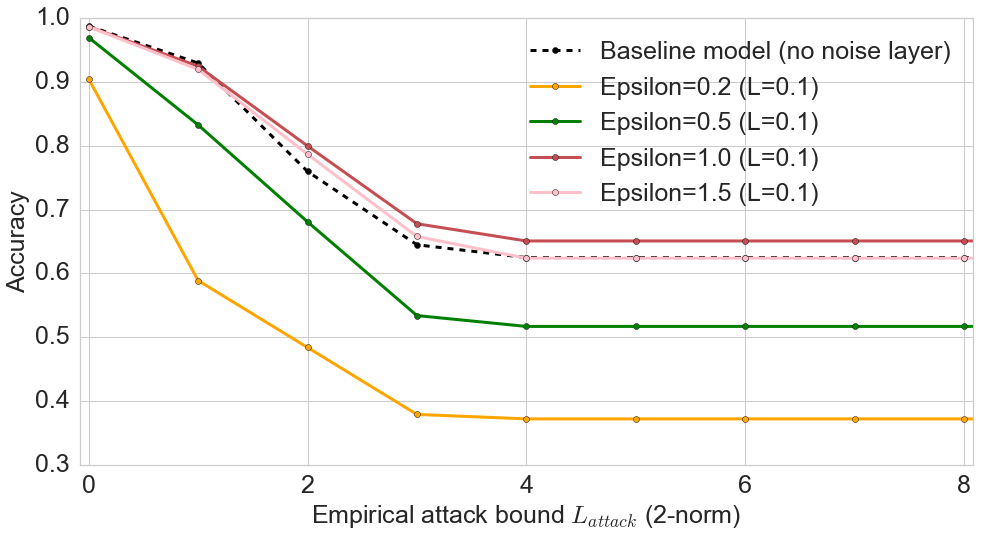

In [146]:
color_list = ['black', "orange", "green", "r", "pink"]
linestyle_list = ['--', '-', '-', '-' , '-']

plt.clf()
fig, (ax) = plt.subplots(1, 1, figsize=(16, 8))
x_range=(0, 8.0)
x_offset = max(x_range)*0.01
plt.xlim((x_range[0]-x_offset, x_range[1]+x_offset))
plt.ylim(0.3, 1.0)
artists = []

curves_labels = []


for i, y in enumerate(y_list):
    if i == 0:
        label = "Baseline model (no noise layer)"
    else:
        eps = eps_list[i-1]
        label = "Epsilon={} (L=0.1)".format(eps)
    curves_labels.append(label)
    art, = plt.plot(
        x, y,
        color=color_list[i],
        linestyle=linestyle_list[i],
        linewidth=3,
        label=label,
        marker='o'
#         marker=marker_list[i],
    #         markersize=plots.utils.markersize
    )
    artists.append([None, None, art])
    ax.set(xlabel=r'Empirical attack bound $L_{attack}$ (2-norm)', ylabel=r'Accuracy')

    l = plt.legend(
        handles=[x[2] for x in artists],
        loc=1,
        fontsize=fontsize)
    l.set_zorder(20)  # put the legend on top
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontsize(fontsize)
        
    ax.xaxis.label.set_fontsize(fontsize)
    ax.yaxis.label.set_fontsize(fontsize)

plt.savefig('epsilon')
    
plt.show()